In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [240]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%precision %.5f
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rc('text', usetex=True)
plt.rc('font',**{'family':'serif','serif':['Palatino']})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Constants

In [3]:
DATA_DIR = "classification_data_HWK2/"
COLS = ["red", "blue","green", "orange", "black", "cyan"]
MARKS = ["^","+","*","o","x","."]

## Reading data

In [9]:
D = {}
for t in ["data", "test"]:
    D[t] = pd.read_csv(DATA_DIR + "EMGaussian" + "." + t, sep = ' ', names = ["x1", "x2"])

## Plot tools

In [244]:
def as_si(x, ndp):
    """
    Credits to xnx
    https://stackoverflow.com/questions/31453422/displaying-numbers-with-x-instead-of-e-scientific-notation-in-matplotlib
    """
    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    return r'{m:s}\times 10^{{{e:d}}}'.format(m=m, e=int(e))


def make_grid(data=None,xmin=-5,xmax=5,ymin=-5,ymax=5,step=20):
    """ Cree une grille sous forme de matrice 2d de la liste des points
    :param data: pour calcluler les bornes du graphe
    :param xmin: si pas data, alors bornes du graphe
    :param xmax:
    :param ymin:
    :param ymax:
    :param step: pas de la grille
    :return: une matrice 2d contenant les points de la grille
    """
    if data is not None:
        xmax, xmin, ymax, ymin = np.max(data[:,0]),  np.min(data[:,0]), np.max(data[:,1]), np.min(data[:,1])
    x, y =np.meshgrid(np.arange(xmin,xmax,(xmax-xmin)*1./step), np.arange(ymin,ymax,(ymax-ymin)*1./step))
    grid=np.c_[x.ravel(),y.ravel()]
    return grid, x, y

def plot_data(data, labels = None):
    """
    Affiche des donnees 2D
    :param data: matrice des donnees 2d
    :param labels: vecteur des labels (discrets)
    :return:
    """
    cols,marks = ["red", "blue","green", "orange", "black", "cyan"],[".","+","*","o","x","^"]
    if labels is None:
        plt.scatter(data[:,0],data[:,1], c='r',  marker="x")
        return
    for i,l in enumerate(sorted(list(set(labels.flatten())))):
        plt.scatter(data[labels==l,0],data[labels==l,1],c=cols[i],marker=marks[i])
        
def plot_frontiere(data, f, step = 200):
    """ Trace un graphe de la frontiere de decision de f
    :param data: donnees
    :param f: fonction de decision
    :param step: pas de la grille
    :return:
    """
    grid,x, y = make_grid(data = data, step = step)
    plt.contourf(x, y, f(grid).reshape(x.shape), colors=('gray', 'blue'), levels=[-1,0,1], alpha=0.3)

## Plotting data

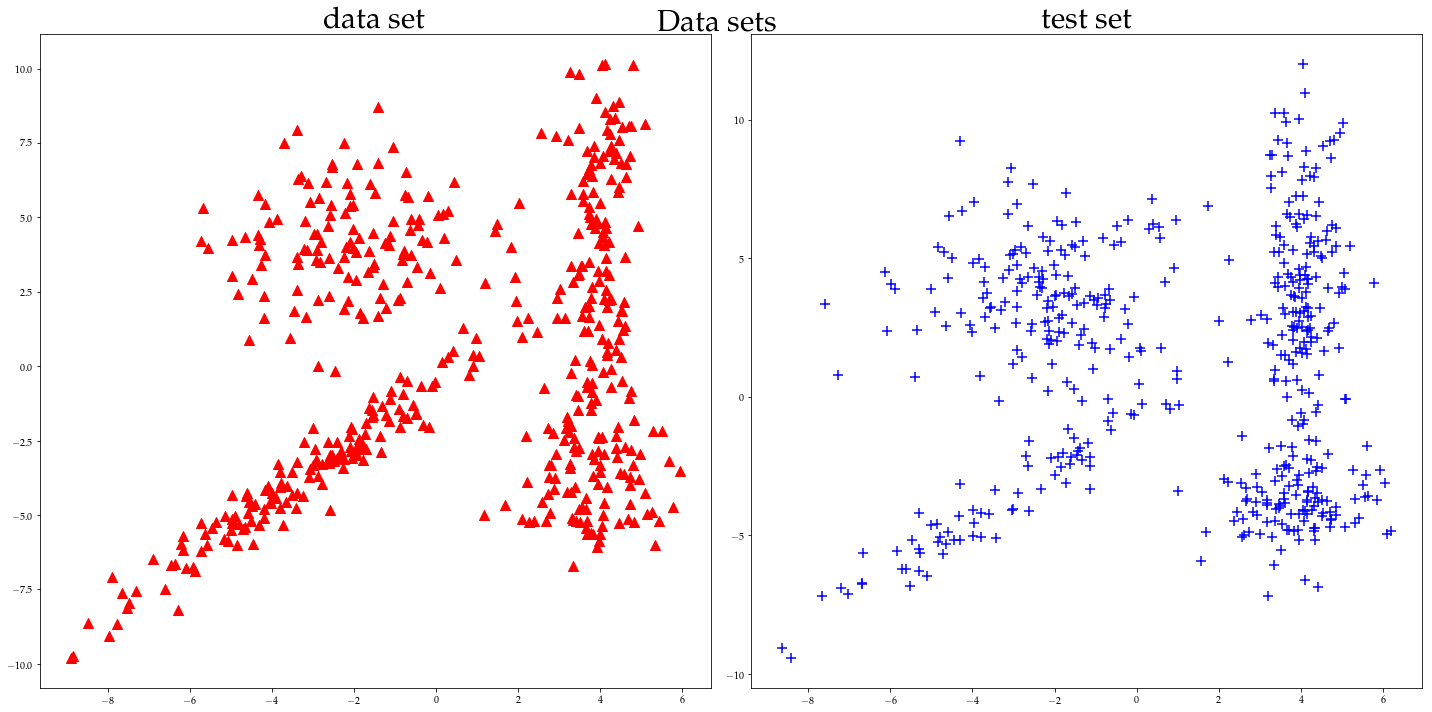

In [14]:
f, ax = plt.subplots(1, 2, figsize = (20, 10))

for j, t in enumerate(["data", "test"]):
    x = D[t].as_matrix()[:, :2]
    ax[j].scatter(x[:, 0], x[:, 1],
                  c = COLS[j], marker=MARKS[j], s = 100)
    ax[j].set_title(t + " set", size = 30);

f.suptitle("Data sets", fontsize = 30)
f.tight_layout();

# Classes

## Kmeans

In [233]:
class K_means(object):
    """
    K-means clustering class
    """
    def __init__(self, K):
        self.K = K
        self.C = None
        self.A = None
        self.distorsion = []
        return
    def _random_centroid(self, datax):
        """
        Draw centroids chosen uniformly at random among the data
        """
        np.random.shuffle(datax)
        return datax[:self.K].reshape(self.K, 1, -1)
    def _one_pass(self, datax):
        """
        One pass of the K_means alternative minimization by computing the distance matrix
        1. Assign each point to the closet centroid
        2. Compute distorsion for each pass and add it to the histogram
        """
        # Compute the distance matrix from each point to each centroid
        distance_matrix = np.linalg.norm(np.tile(datax, (self.K, 1, 1)) - self.C, axis = 2)
        # Get the argmin of the distance for all centroids
        self.A = distance_matrix.argmin(axis = 0)
        # Get the current value of distorsion
        ## Store the minimum distance
        min_dist = distance_matrix.min(axis = 0)
        self.distorsion.append((min_dist ** 2).sum())
        # Recompute the centroids
        self.C = np.array([(lambda a : datax[a].sum(axis = 0)/a.sum())(self.A == k)\
                           for k in range(self.K)]).reshape(self.K, 1, -1)
    def fit(self, datax):
        """
        """
        # Initialisation
        ## Of centroids
        self.C = self._random_centroid(datax)
        ## Stop condition
        stop = False
        while (stop == False):
            self._one_pass(datax)
            if (len(self.distorsion) > 1):
                stop = True if self.distorsion[-2] - self.distorsion[-1] < 1 else False
        return self.C, self.A
    def predict(self, datax):
        """
        Predict cluster given current centroids
        """
        # Compute the distance matrix from each point to each centroid
        distance_matrix = np.linalg.norm(np.tile(datax, (self.K, 1, 1)) - self.C, axis = 2)
        return distance_matrix.argmin(axis = 0)

# Results

## K-means with random initializations - training data

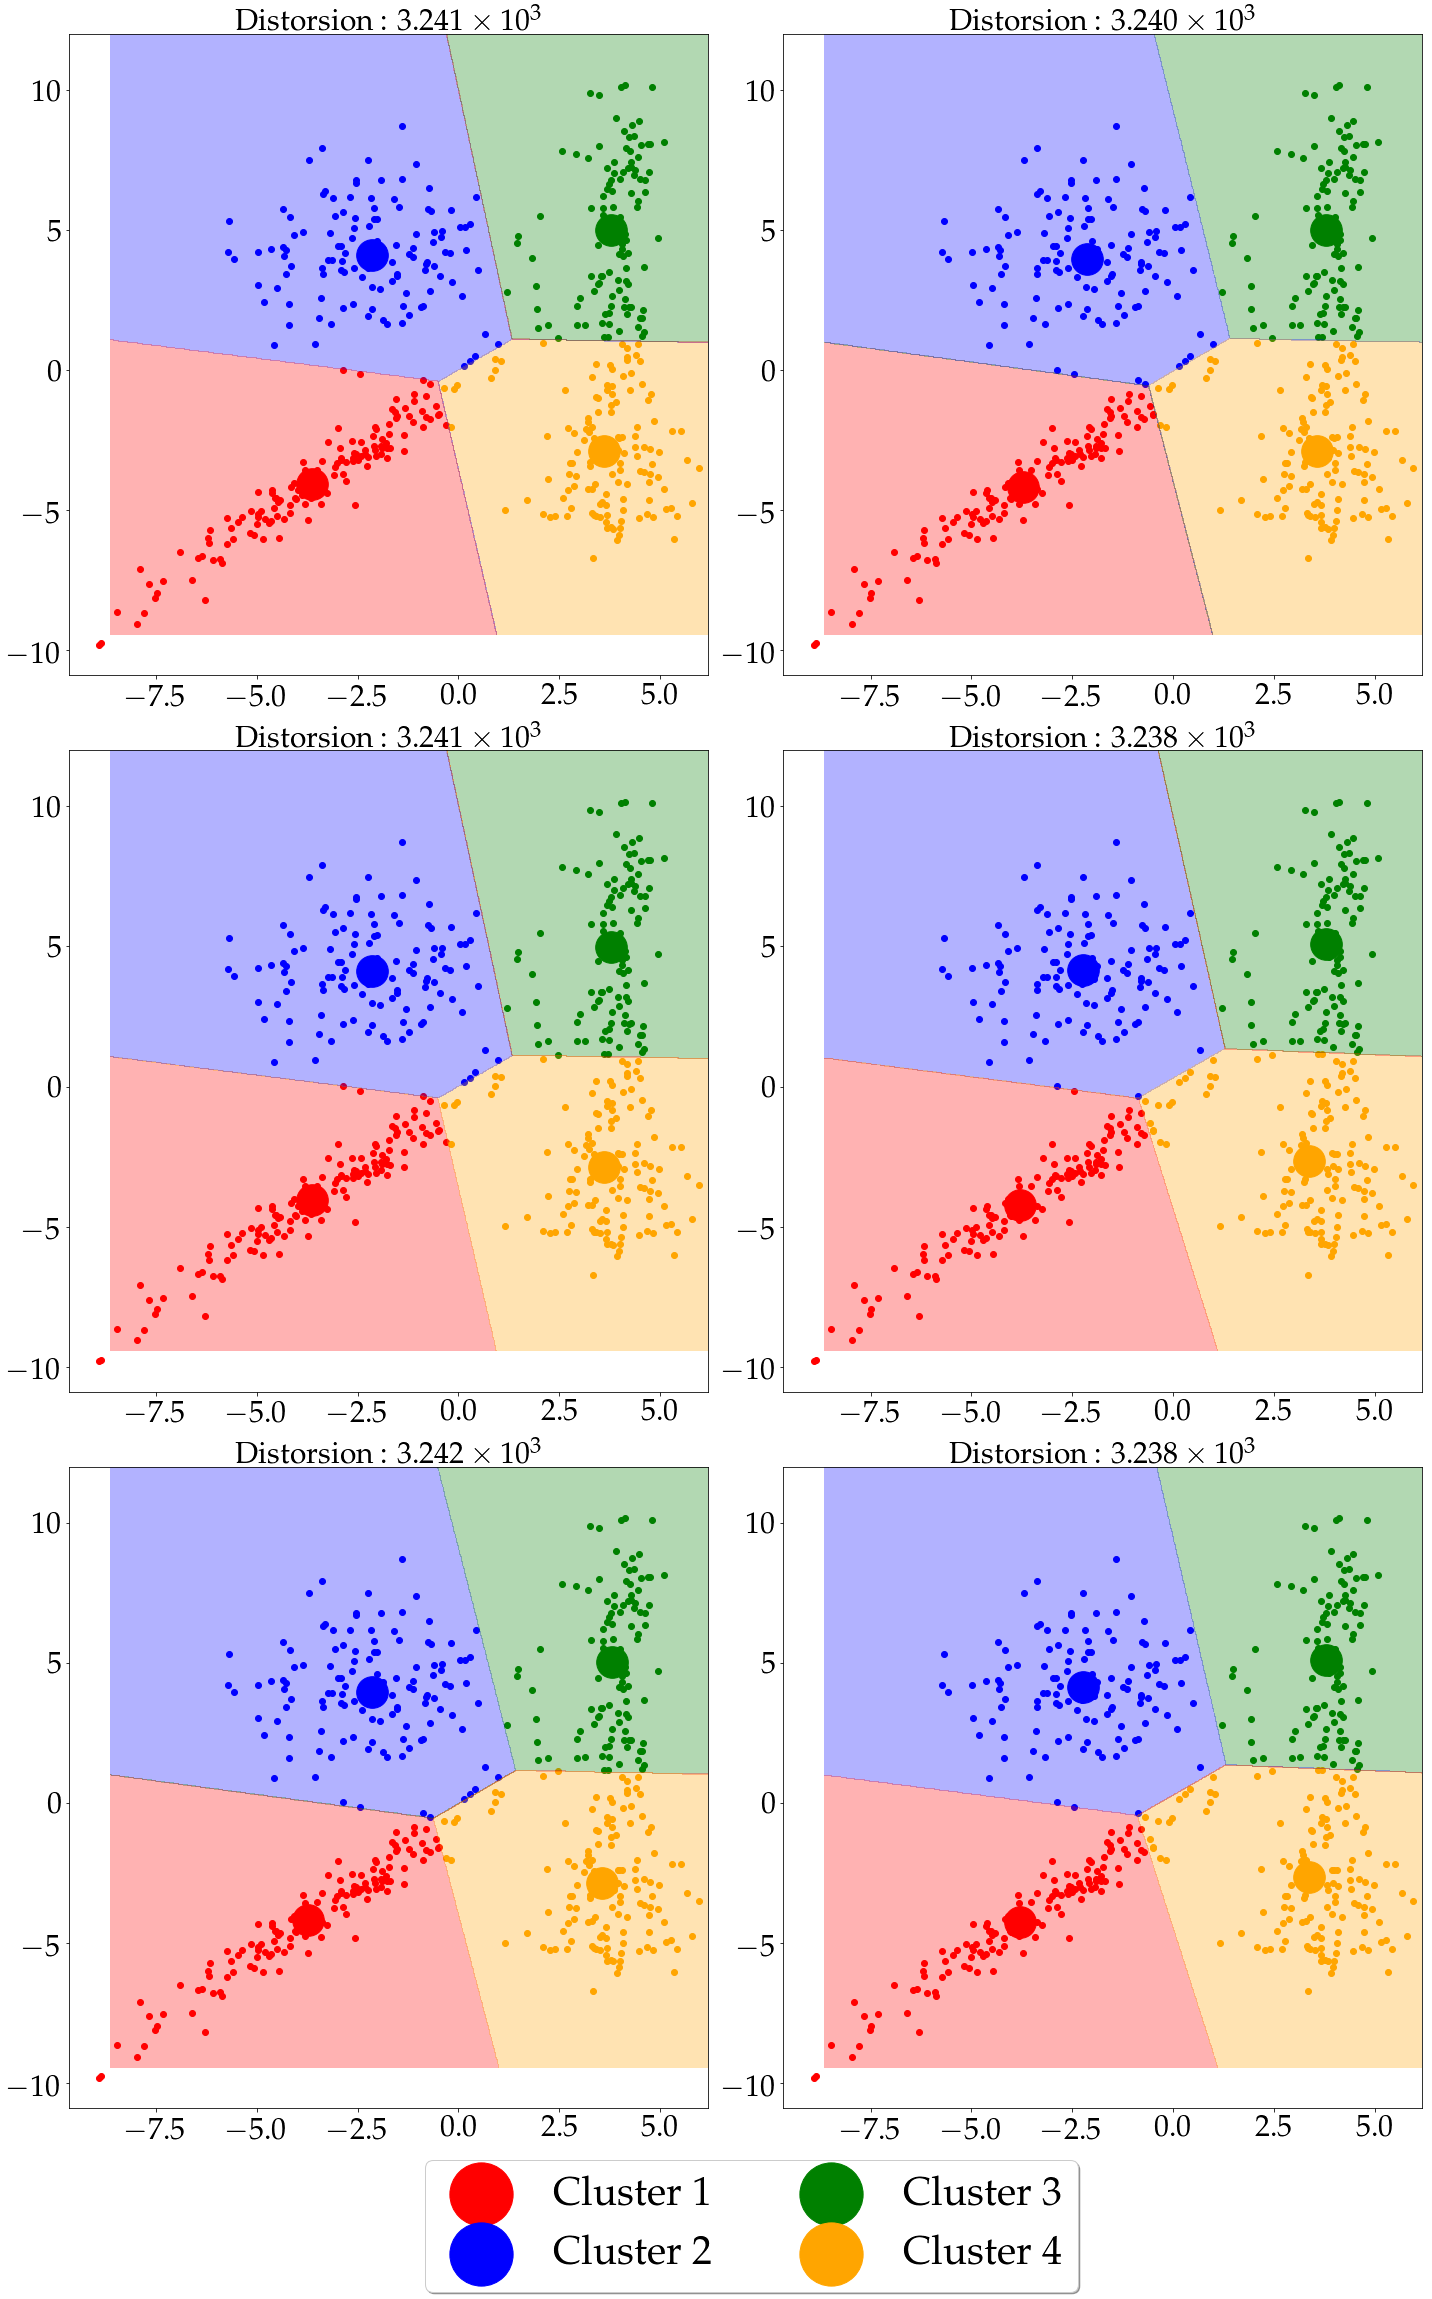

In [268]:
f, ax = plt.subplots(3, 2, figsize = (20, 30))

datax = D['data'].as_matrix()
K = 4

for k in range(6):
    # print ("----------------- number {} --------------------".format(k))
    classifier = K_means(K)
    # Fit the classifier
    C, A = classifier.fit(datax)
    C = C.reshape(K, 2)
    for i,j in enumerate(np.arctan2(C[:, 0], C[:, 1]).argsort()):
        ax[k // 2][k % 2].scatter(datax[A == j][:, 0],
                                  datax[A == j][:, 1],
                                  c = COLS[i])
        ax[k // 2][k % 2].scatter(C[j, 0],
                                  C[j, 1],
                                  c = COLS[i],
                                  marker = "o",
                                  s = 1000,
                                  label = "Cluster {}".format(i + 1)
                                 )
    grid, x_grid, y_grid = make_grid(data = x, step = 1000)
    ax[k // 2][k % 2].contourf(x_grid, y_grid,
                               classifier.predict(grid).reshape(x_grid.shape),
                               colors = [COLS[c] for c in np.arctan2(C[:, 0], C[:, 1])\
                                         .argsort().argsort()],
                               levels = [-1, 0, 1, 2, 3],
                               alpha = 0.3,
                              )
    ax[k // 2][k % 2].set_title(r"Distorsion : ${}$".format(as_si(classifier.distorsion[-1], 3)),
                               fontsize = 30)

ax[k // 2][j % 2].legend(loc='upper center', bbox_to_anchor=(-0.05, -0.05),
            fancybox=True, shadow=True, ncol=2, fontsize = 40,
            markerscale = 2)

f.savefig("images/4_a.png",  bbox_inches='tight', pad_inches=0)
f.tight_layout();

# Test zone

In [104]:
datax = D['data'].as_matrix()

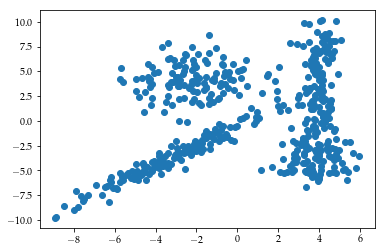

In [105]:
plt.scatter(datax[:, 0], datax[:, 1])

In [142]:
Q = K_means(4);
C, A,cen  = Q.fit(datax)

In [143]:
Q.distorsion

[10374.08646,
 6602.31714,
 5394.39203,
 4572.74642,
 4454.47380,
 4417.02863,
 4390.12415,
 4343.59605,
 4317.09508,
 4305.75930]